### Pronóstico de Series de Tiempo con Machine Learning - Volumen de Entrada Presa Chicayán

Se presenta un modelo de pronóstico de series de tiempo para el **Volumen de Entrada de la Presa Chicayán** utilizando Algoritmos de Machine Learning.

#### Pronóstico de Series de Tiempo Multi-paso Directo

Al trabajar con Series de Tiempo es muy poco común tratar de pronosticar únicamente el siguiente elemento en la serie $(t_{+1})$. En lugar de esto, casi siempre es necesario predecir un *intervalo completo* en el futuro $(t_{+1},...,t_{+n})$. Muchas estrategias permiten esta estimación.

Se utilizará una estrategia llamada **Regresión Multi-paso Directa**, que funciona de la siguiente manera:

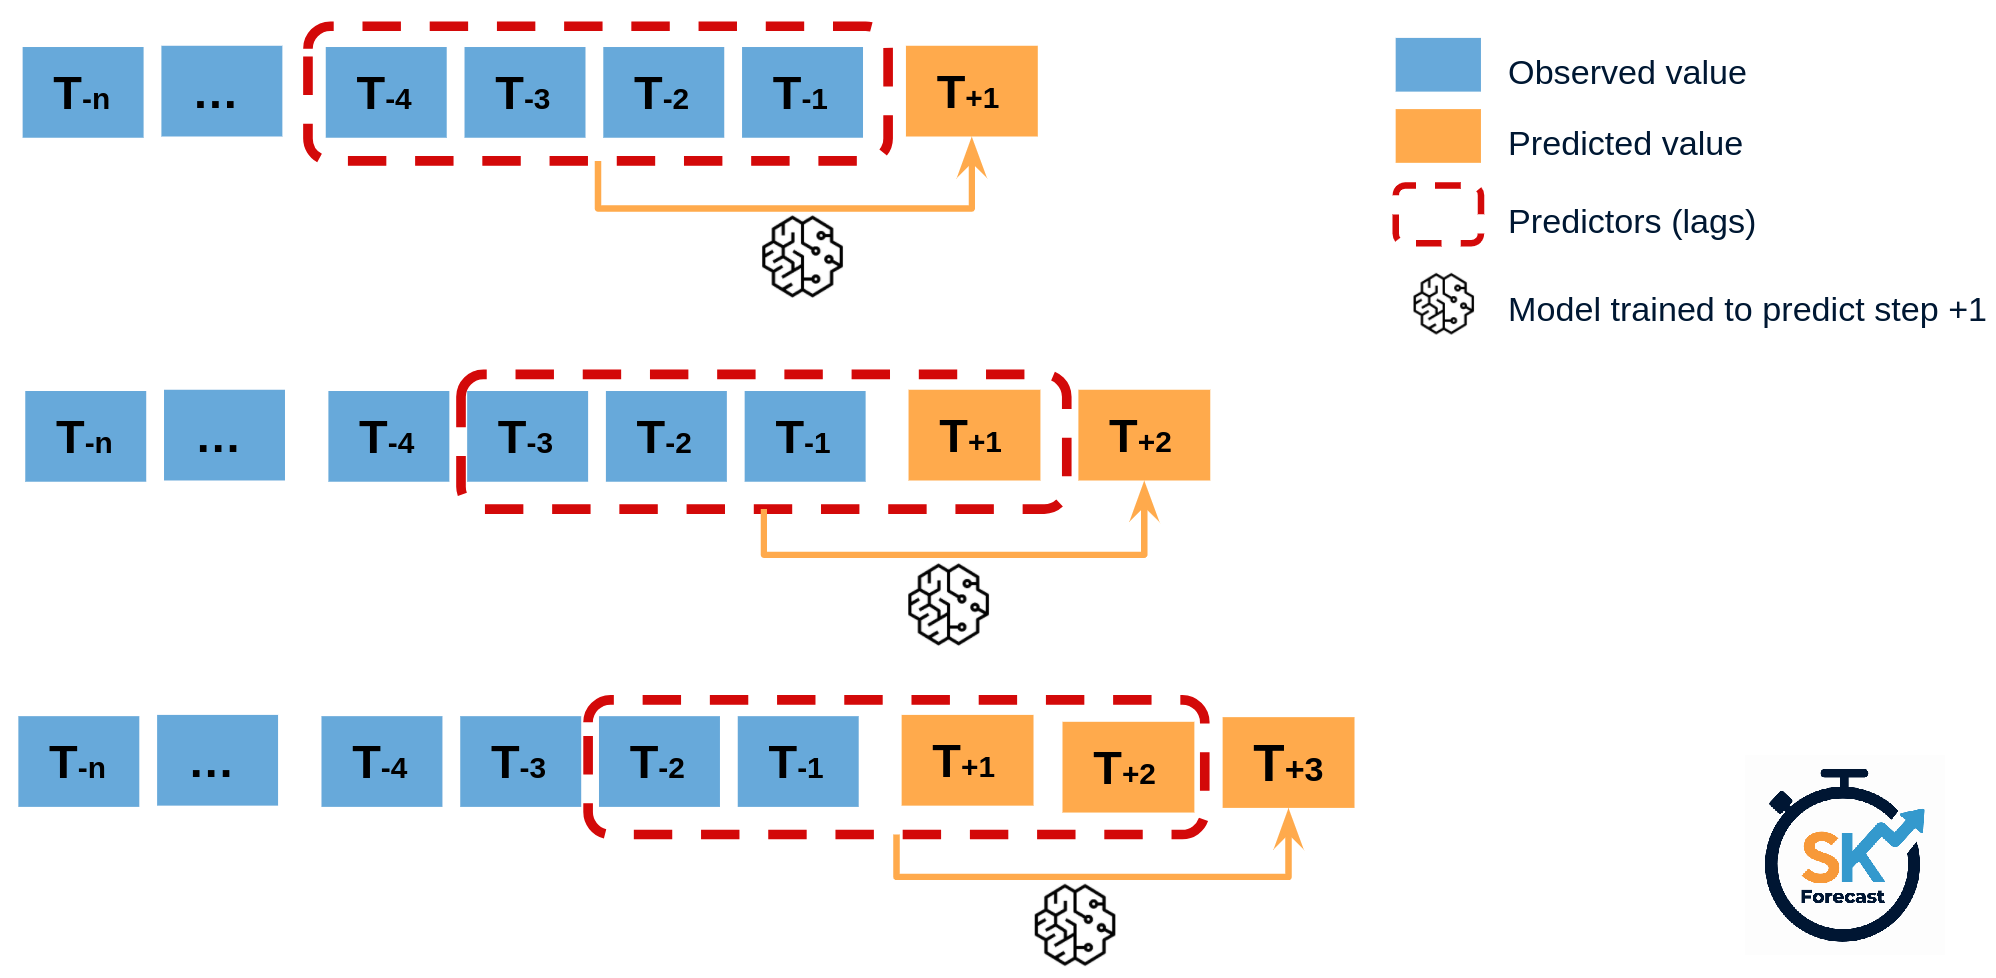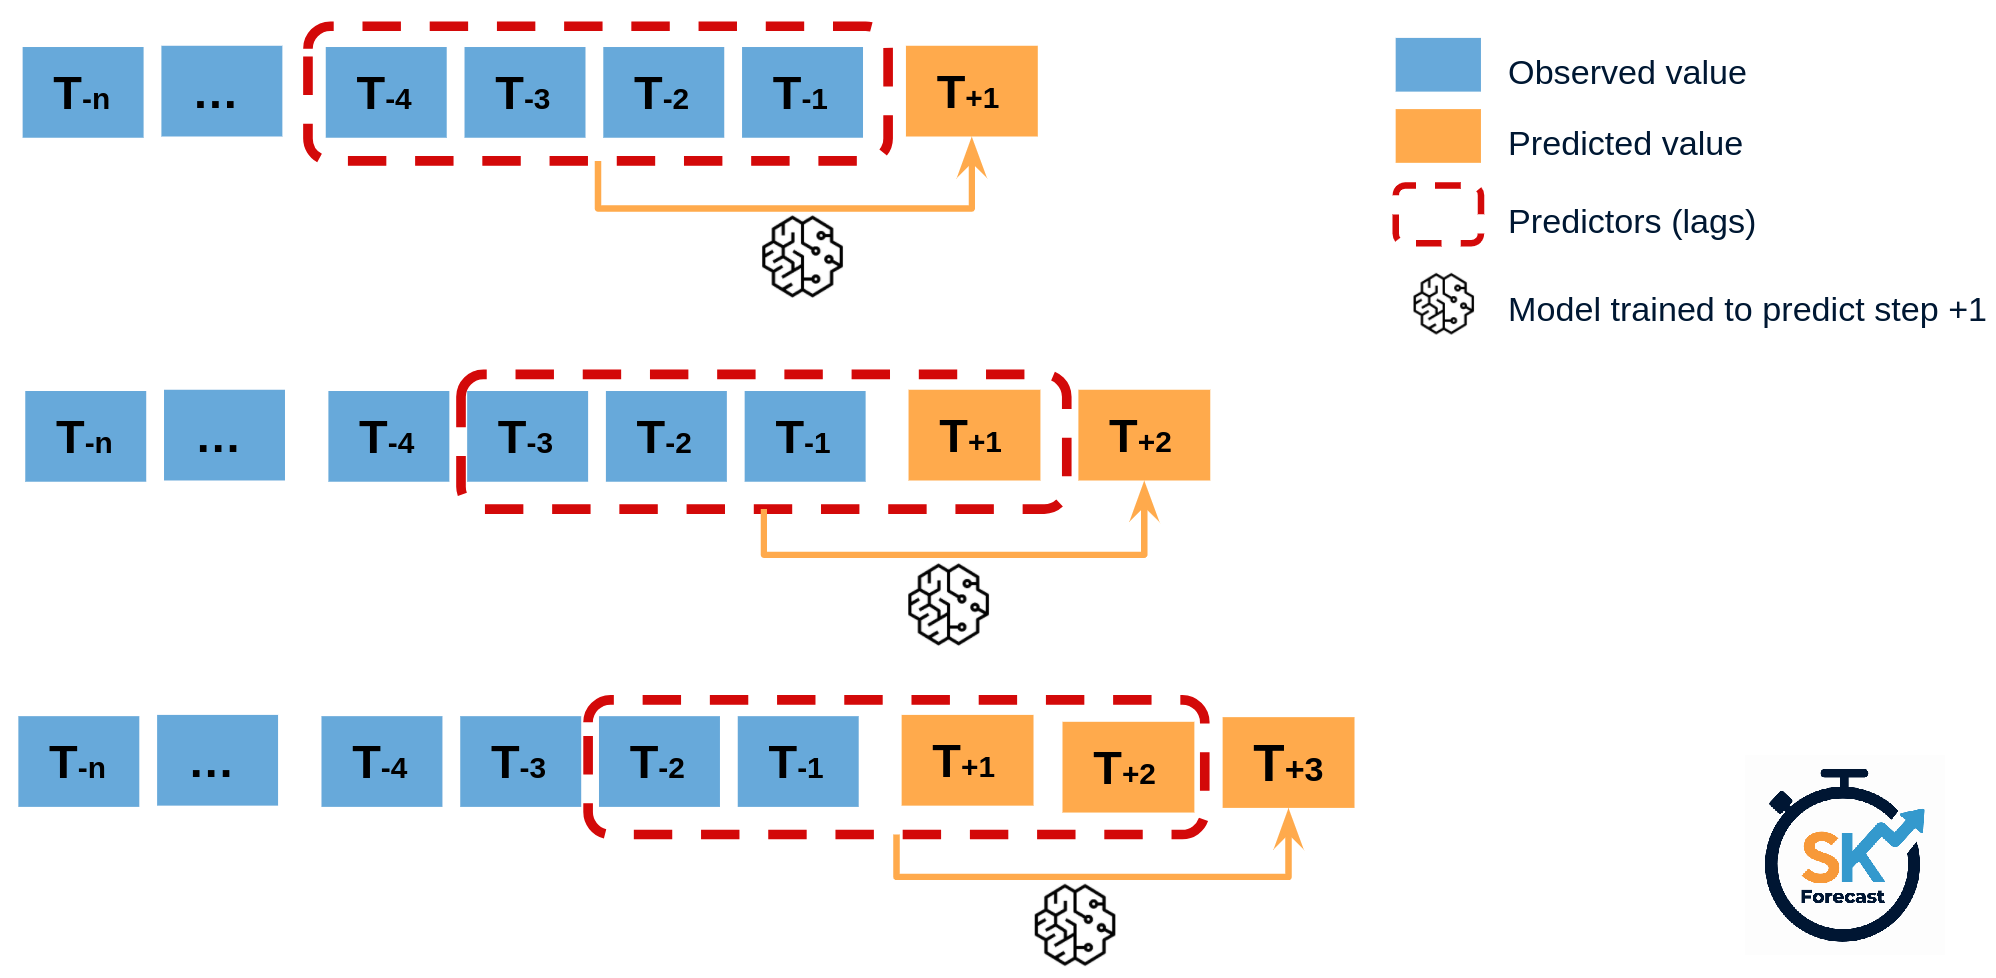

https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

En ella, **un modelo de regresión por cada paso** se entrena simultáneamente para obtener el intervalo completo de pronóstico.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster

In [2]:
data = pd.read_csv(r'Inlet_Dates.csv')
data.head()

,Year,Inlet
0,1979-01-01,176
1,1980-01-01,90
2,1981-01-01,913
3,1982-01-01,30
4,1983-01-01,86


In [3]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'Year': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('YS')
data = data.sort_index()
data.head()

,Inlet
date,
1979-01-01,176
1980-01-01,90
1981-01-01,913
1982-01-01,30
1983-01-01,86


Train dates : 1979-01-01 00:00:00 --- 2014-01-01 00:00:00  (n=36)
Test dates  : 2015-01-01 00:00:00 --- 2024-01-01 00:00:00  (n=10)


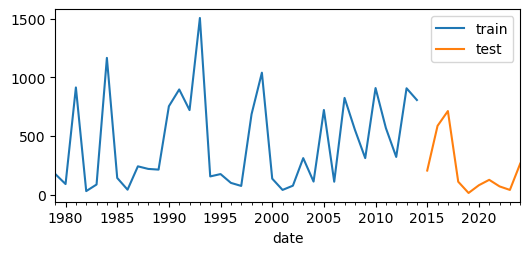

In [4]:
# Split data into train-test
# ==============================================================================
steps = 10
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Inlet'].plot(ax=ax, label='train')
data_test['Inlet'].plot(ax=ax, label='test')
ax.legend();

In [5]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterDirect(
                 regressor     = RandomForestRegressor(n_estimators = 500, random_state=123),
                 steps         = 10,
                 lags          = 8,  # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

In [6]:
forecaster.fit(y=data_train['Inlet'])
forecaster

================ 
ForecasterDirect 
================ 
Regressor: RandomForestRegressor 
Lags: [1 2 3 4 5 6 7 8] 
Window features: None 
Window size: 8 
Maximum steps to predict: 10 
Series name: Inlet 
Exogenous included: False 
Exogenous names: None 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1979-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: YS-JAN 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-04 19:55:03 
Last fit date: 2025-05-04 19:55:05 
Skforecast version: 0.16.0 
Python version: 3.12.2 
Forecaster id: None

In [7]:
# Predictions
# ==============================================================================
steps = 10
predictions = forecaster.predict(steps=steps)
predictions.head(10)

2015-01-01    566.080
2016-01-01    479.422
2017-01-01    205.770
2018-01-01    259.318
2019-01-01    280.082
2020-01-01    206.434
2021-01-01    305.196
2022-01-01    369.190
2023-01-01    242.430
2024-01-01    338.814
Freq: YS-JAN, Name: pred, dtype: float64

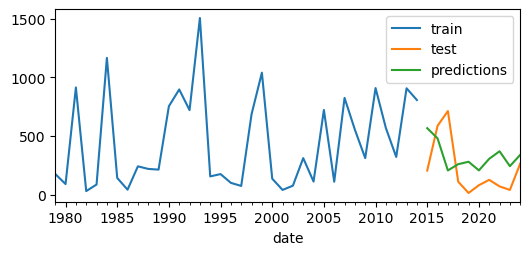

In [8]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Inlet'].plot(ax=ax, label='train')
data_test['Inlet'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [9]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['Inlet'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 67528.84035999994


In [10]:
forecaster.fit(y=data['Inlet'])
forecaster

================ 
ForecasterDirect 
================ 
Regressor: RandomForestRegressor 
Lags: [1 2 3 4 5 6 7 8] 
Window features: None 
Window size: 8 
Maximum steps to predict: 10 
Series name: Inlet 
Exogenous included: False 
Exogenous names: None 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1979-01-01 00:00:00'), Timestamp('2024-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: YS-JAN 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-04 19:55:03 
Last fit date: 2025-05-04 19:55:08 
Skforecast version: 0.16.0 
Python version: 3.12.2 
Forecaster id: None

In [11]:
# Predictions
# ==============================================================================
steps = 10
predictions = forecaster.predict(steps=steps)
predictions.head(10)

2025-01-01    401.948
2026-01-01    473.126
2027-01-01    448.566
2028-01-01    630.196
2029-01-01    656.666
2030-01-01    804.402
2031-01-01    609.338
2032-01-01    628.550
2033-01-01    456.016
2034-01-01    507.614
Freq: YS-JAN, Name: pred, dtype: float64

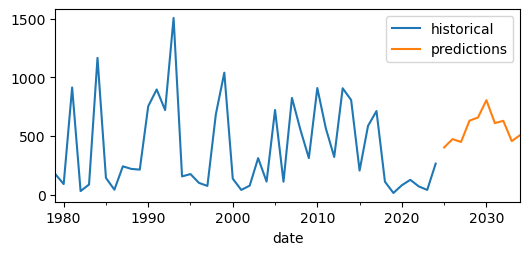

In [12]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data['Inlet'].plot(ax=ax, label='historical')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [13]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterDirect(
                 regressor = RandomForestRegressor(random_state=123),
                 steps         = 10,
                 lags      = 12, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Training and validation folds
cv = TimeSeriesFold(
      steps              = 10,
      initial_train_size = int(len(data_train) * 0.5),
      refit              = True,
      fixed_train_size   = False,

    )

# Candidate values for lags
lags_grid = [1,2,3,4,5,6,7,8]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250,500],
    'max_depth': [3, 8, 20]
}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['Inlet'],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid: 100%|██████████| 8/8 [02:00<00:00, 15.01s/it]  

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 8, 'n_estimators': 100}
  Backtesting metric: 152157.53595


In [14]:
results_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 8, 'n_estimators': 100}",152157.535950,8,100
1,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 20, 'n_estimators': 100}",152157.535950,20,100
2,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 100}",153573.710998,3,100
3,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 20, 'n_estimators': 250}",155948.535850,20,250
4,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 8, 'n_estimators': 250}",155948.535850,8,250
...,...,...,...,...,...,...
67,"[1, 2, 3, 4, 5, 6, 7, 8]","[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 20, 'n_estimators': 100}",282637.857444,20,100
68,"[1, 2, 3, 4, 5, 6, 7, 8]","[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 3, 'n_estimators': 100}",282902.354763,3,100
69,"[1, 2, 3, 4, 5, 6, 7, 8]","[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 8, 'n_estimators': 250}",283470.077742,8,250
70,"[1, 2, 3, 4, 5, 6, 7, 8]","[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 20, 'n_estimators': 250}",283470.077742,20,250


In [15]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=123)
forecaster = ForecasterDirect(
                 regressor = regressor,
                 steps = 10,
                 lags  = 3,
                 transformer_y = StandardScaler()
             )
forecaster.fit(y=data_train['Inlet'])
forecaster

================ 
ForecasterDirect 
================ 
Regressor: RandomForestRegressor 
Lags: [1 2 3] 
Window features: None 
Window size: 3 
Maximum steps to predict: 10 
Series name: Inlet 
Exogenous included: False 
Exogenous names: None 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1979-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: YS-JAN 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    8, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-04 19:57:08 
Last fit date: 2025-05-04 19:57:08 
Skforecast version: 0.16.0 
Python version: 3.12.2 
Forecaster id: None

In [16]:
# Predictions
# ==============================================================================
steps = 10
predictions = forecaster.predict(steps=steps)
predictions

2015-01-01    740.207500
2016-01-01    881.070000
2017-01-01    324.120000
2018-01-01    363.740000
2019-01-01    183.780000
2020-01-01    248.822857
2021-01-01    504.633333
2022-01-01    657.800000
2023-01-01    320.015000
2024-01-01    246.850000
Freq: YS-JAN, Name: pred, dtype: float64

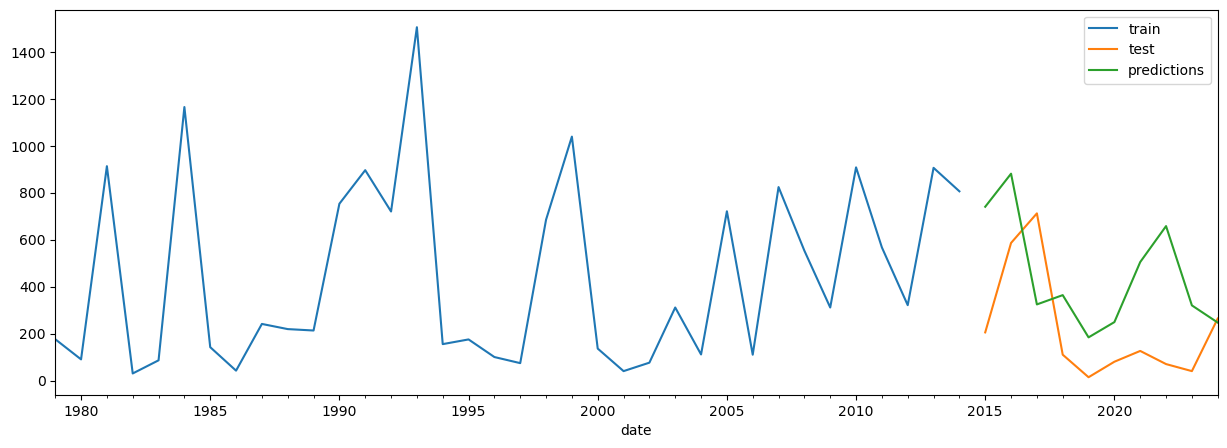

In [17]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 5))
data_train['Inlet'].plot(ax=ax, label='train')
data_test['Inlet'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [35]:
# Backtesting partitions using TimeSeriesFold
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 10, 
         initial_train_size = len(data) - 26,  # Last 9 years are separated for the backtest
         window_size        = 20,
         fixed_train_size   = False,
         refit              = True,
     )

cv.split(X=data, as_pandas=True)

Information of folds
--------------------
Number of observations used for initial training: 20
Number of observations used for backtesting: 26
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 6 observations.

Fold: 0
    Training:   1979-01-01 00:00:00 -- 1998-01-01 00:00:00  (n=20)
    Validation: 1999-01-01 00:00:00 -- 2008-01-01 00:00:00  (n=10)
Fold: 1
    Training:   1979-01-01 00:00:00 -- 2008-01-01 00:00:00  (n=30)
    Validation: 2009-01-01 00:00:00 -- 2018-01-01 00:00:00  (n=10)
Fold: 2
    Training:   1979-01-01 00:00:00 -- 2018-01-01 00:00:00  (n=40)
    Validation: 2019-01-01 00:00:00 -- 2024-01-01 00:00:00  (n=6)



,fold,train_start,train_end,last_window_start,last_window_end,test_start,test_end,test_start_with_gap,test_end_with_gap,fit_forecaster
0,0,0,20,0,20,20,30,20,30,True
1,1,0,30,10,30,30,40,30,40,True
2,2,0,40,20,40,40,46,40,46,True


In [36]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['Inlet'],
                                    cv         = cv,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                                )
metric

Information of folds
--------------------
Number of observations used for initial training: 20
Number of observations used for backtesting: 26
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 6 observations.

Fold: 0
    Training:   1979-01-01 00:00:00 -- 1998-01-01 00:00:00  (n=20)
    Validation: 1999-01-01 00:00:00 -- 2008-01-01 00:00:00  (n=10)
Fold: 1
    Training:   1979-01-01 00:00:00 -- 2008-01-01 00:00:00  (n=30)
    Validation: 2009-01-01 00:00:00 -- 2018-01-01 00:00:00  (n=10)
Fold: 2
    Training:   1979-01-01 00:00:00 -- 2018-01-01 00:00:00  (n=40)
    Validation: 2019-01-01 00:00:00 -- 2024-01-01 00:00:00  (n=6)



100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


,mean_squared_error
0,142013.359121


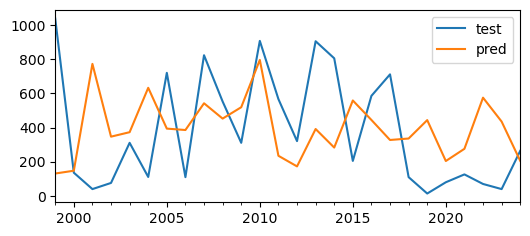

In [37]:
# Plot backtest predictions vs real values
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data.loc[predictions_backtest.index, 'Inlet'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();